In [4]:
import skvideo.io
import numpy as np
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import tensorly as tl
import matplotlib.ticker as ticker
import tensorsketch
from tensorsketch.tensor_approx import TensorApprox,eval_rerr
import warnings
from tensorly.decomposition import tucker
from tensorsketch.util import RandomInfoBucket, random_matrix_generator
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

Using numpy backend.
Using numpy backend.


In [2]:
#seafloor = skvideo.io.vread("seafloor.mp4")
#print(seafloor.shape)
#np.save("seafloor.npy", seafloor)

In [3]:
#seafloor = np.load("seafloor.npy")

In [4]:
#walk = skvideo.io.vread("walk.mp4")
#print(walk.shape)
#for i in np.arange(9):
#    print(i)
#    videoframe = skvideo.utils.rgb2gray(np.reshape(walk[277*i:277*(i+1),:,:,:]),[277,1080,1920])
#    np.save("data/grey_walk"+str(i)+".npy", videoframe)

In [14]:
test = np.load("data/grey_walk"+str(2)+".npy")

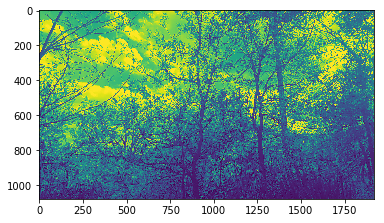

In [19]:
plt.imshow(test[0,:,:])

In [24]:
X= test[0,:,:]

In [25]:
from sklearn.decomposition import TruncatedSVD

In [29]:
u, s, vh = np.linalg.svd(X)

In [30]:
u.shape

(1080, 1080)

In [31]:
s.shape

(1080,)

In [32]:
vh.shape

(1920, 1920)

In [65]:
def plot_rank(k):
    X_new = u[:,range(k)]@np.diag(s[range(k)]) @ vh[range(k),:]
    plt.imshow(X_new)
    plt.title('Rank = '+str(k))
    return X_new

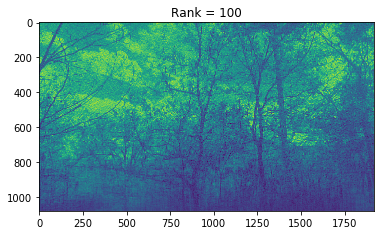

In [72]:
X_new = plot_rank(100)

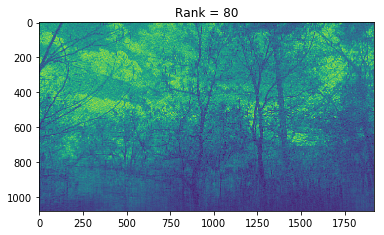

In [73]:
X_new = plot_rank(80)

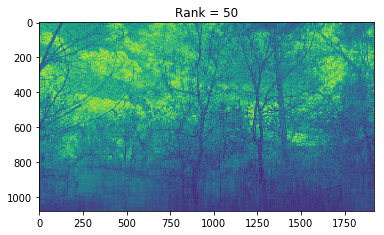

In [66]:
X_new = plot_rank(50)

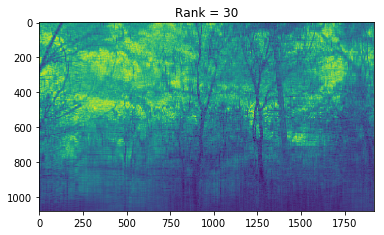

In [67]:
X_new = plot_rank(30)

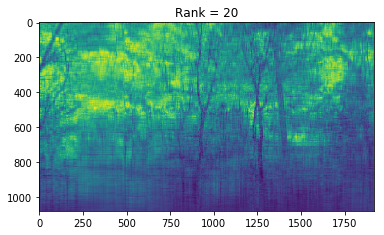

In [68]:
X_new = plot_rank(20)

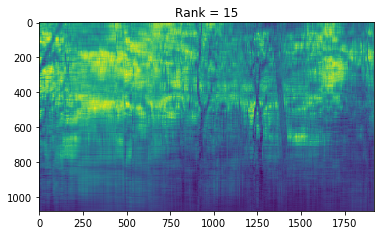

In [69]:
X_new = plot_rank(15)

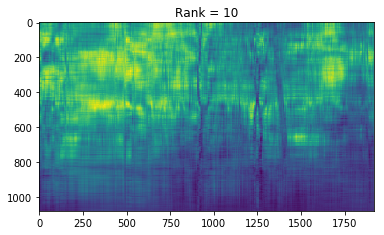

In [70]:
X_new = plot_rank(10)

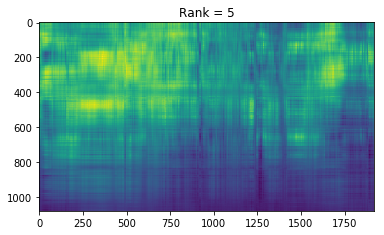

In [71]:
X_new = plot_rank(5)

In [1]:
def ts_sketch(data, data_dim, ks, ss, t_dim = 0, t_start = 0, t_end = 0, seed = 1): 
# Efficient computation of sketch for time series data, where the map is gprod
    pad_dim = [(t_start, data_dim[t_dim]- t_end) if idx == t_dim else (0,0) for idx, size in enumerate(data_dim) ]
    data_aug = np.pad(data, pad_dim, 'constant', constant_values = 0) 
    arm_subrms = [np.random.normal(ss[i],) for i in np.arange(len(ks))]
    for i in np.arange(len(ks)): 
        if i == t_dim: 
            core_rm = np.random.normal(size = [ss[i],t_end -t_start]) 
            core_rm = np.pad(core_rm,[(0,0), (t_start, data_dim[t_dim]- t_end)],'constant', constant_values = 0)
        else: 
            core_rm = np.random.normal(size = [ss[i],data_dim[i]])
        core_rms.append(core_rm) 

In [6]:
 def sketch_arm_rm_generator(tensor_shape, ks, Rinfo_bucket):
        '''
        :param tensor_shape: shape of the tensor, an 1-d array
        :param ks: k, the reduced dimension of the arm tensors, an 1-d array 
        '''
        std, typ, random_seed, sparse_factor = Rinfo_bucket.get_info()
        total_num = np.prod(tensor_shape)
        for n in range(len(tensor_shape)):
            n1 = total_num//tensor_shape[n] # I_(-n)
            # Construct the transposed matrix, because for some test matrices,  
            # like sparse sign, the direction of the mutliplication matters. 
            yield random_matrix_generator(ks[n], n1 , Rinfo_bucket).T

In [7]:
def update_sketch(arm_sketches, core_sketch, data, ks, ss, t_dim = 0, t_start = 0, t_end = 0, rm_typ = 'g', typ = 'turnstile', seed = 1):
    if typ == 'turnstile': 
        new_sketch = tensorsketch.sketch.Sketch(data, ks, seed, ss)
        [new_arm_sketches, new_core_sketch] = new_sketch.get_sketches()
        for i in range(len(arm_sketches)): 
            arm_sketches[i] = arm_sketches[i] + new_arm_sketches[i]
        core_sketch = core_sketch + new_core_sketch
        # print(new_core_sketch)
        # print(new_arm_sketches)
        return [arm_sketches, core_sketch]
    elif typ == "turnstile_ts": 
        pass  

In [8]:
def init_sketch(data_dim, ks, ss): 
    arm_sketches = []
    for i in np.arange(len(data_dim)): 
        arm_sketches.append(np.zeros([data_dim[i],ks[i]]))
    core_sketch = np.zeros(ss)
    return [arm_sketches, core_sketch]

In [9]:
def video_sketch(data_files, data_dim = [2493,1080,1920],ks = [20,20,20], ss = [41,41,41], rm_typ = 'gprod', typ = 'turnstile', seed = 1):  
    [arm_sketches, core_sketch] = init_sketch(data_dim, ks, ss)
    for idx, data_file in enumerate(data_files): 
        print(idx)
        data = np.load(data_file)
        data_aug = np.zeros(data_dim)
        data_aug[idx*int(data_dim[0]/len(data_files)):(idx+1)*int(data_dim[0]/len(data_files)),:,:] =  data
        [arm_sketches, core_sketch] = update_sketch(arm_sketches, core_sketch, data_aug, ks, ss, rm_typ = rm_typ, typ = typ, seed = 1)
    return [arm_sketches, core_sketch]

In [10]:
def store_sketch(sketch, name = 'walk'): 
    arm_sketches, core_sketch = sketch
    for idx, arm_sketch in enumerate(arm_sketches): 
        np.save("data/"+name+"_arm"+str(idx)+".npy", arm_sketch)
    np.save("data/"+name +"_core.npy", core_sketch)

In [11]:
def load_sketch(name, dim):
    arm_sketches = []
    for i in np.arange(dim): 
        arm_sketches.append(np.load("data/"+name+"_arm"+str(i)+".npy"))
    core_sketch = np.load("data/"+name+"_core.npy")
    return [arm_sketches, core_sketch]

In [13]:
for k in [20,50,80,150,200,250,300]:
    ks = np.repeat(k,3)
    ss = 2*ks+1
    walk_sketch = video_sketch(["data/grey_walk"+str(i)+".npy" for i in np.arange(9)],ks=ks, ss=ss)
    store_sketch(walk_sketch, name = 'walk_k'+str(k))

0


Using numpy backend.


1


Using numpy backend.


2


Using numpy backend.


3


Using numpy backend.


KeyboardInterrupt: 

In [13]:
walk_sketch = load_sketch('walk_k20', 3)

In [14]:
arm_sketches, core_sketch = walk_sketch

In [19]:
ks = np.array([20,20,20]); ss = 2*ks+1

In [20]:
sketch_one_pass = tensorsketch.sketch_recover.SketchOnePassRecover(arm_sketches, core_sketch, \
                tensorsketch.util.TensorInfoBucket([2493,1080,1920], ks, [10,10,10] , ss),\
                tensorsketch.util.RandomInfoBucket(random_seed = 1)) 

Using numpy backend.


In [21]:
walk_hat, tucker_arms, tucker_core = sketch_one_pass.recover()

In [31]:
data_norm2 = 0
err_norm2 = 0
for i in np.arange(1): 
    print(i)
    partition = np.load("data/grey_walk"+str(i)+".npy")
    data_norm2 = data_norm2 + np.linalg.norm(partition)**2
    err_norm2 = err_norm2 + np.linalg.norm(partition - walk_hat[i*277:(i+1)*277,:,:])**2
print(np.sqrt(err_norm2/data_norm2))

0
0.378983897691343


In [ ]:
k = 300
print(k)
walk_sketch = load_sketch('walk_k'+str(k), 3)
arm_sketches, core_sketch = walk_sketch
[tucker_arms,tucker_core] = pickle.load(open("data/walk_tucker_k"+str(k)+"_r"+str(10)+".pickle",'rb'))
kmeans = KMeans(n_clusters =3,random_state=0).fit(arm_sketches[0])
plt.figure()
plt.plot(kmeans.labels_)
plt.title('sketch'+ str(k))
kmeans2 = KMeans(n_clusters =3,random_state=0).fit(tucker_arms[0])
plt.figure()
plt.plot(kmeans2.labels_)
plt.title('tucker'+str(k))

In [ ]:
kmeans2.labels_

In [13]:
kmeans2.labels_[np.arange(100)]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [14]:
kmeans2.labels_[2300:2493]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

20
50
80
100
150
200
250
300


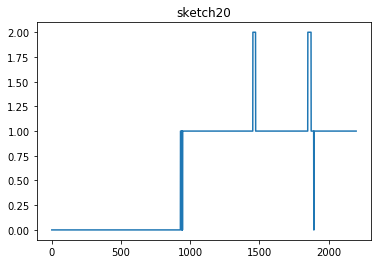

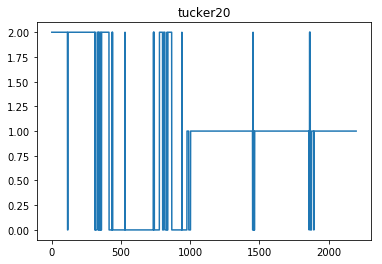

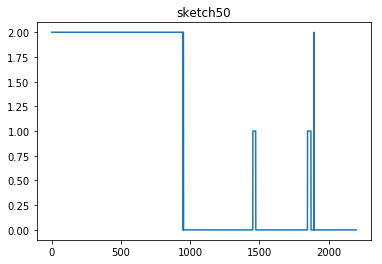

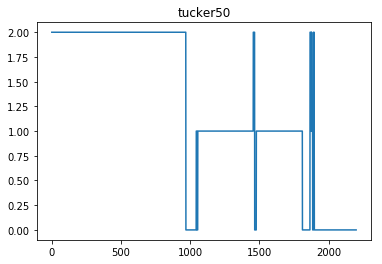

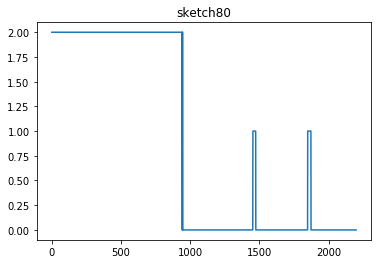

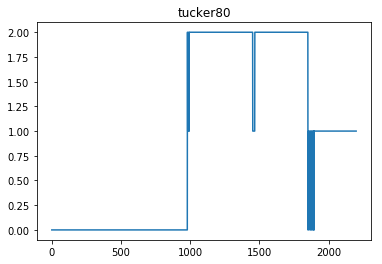

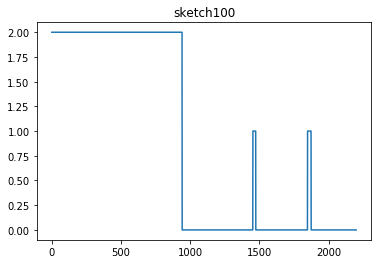

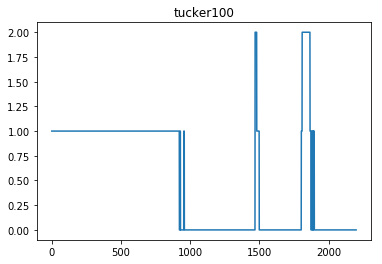

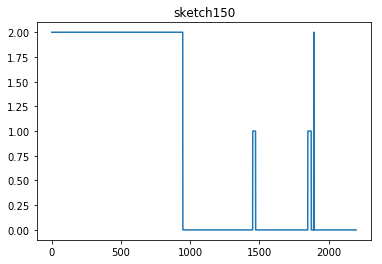

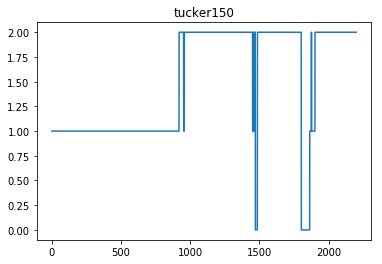

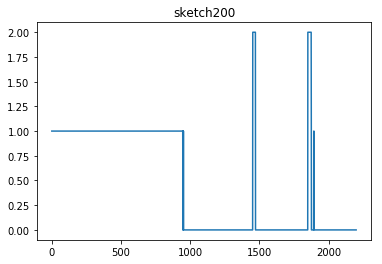

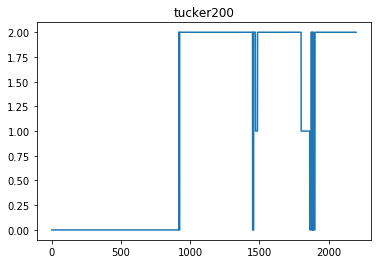

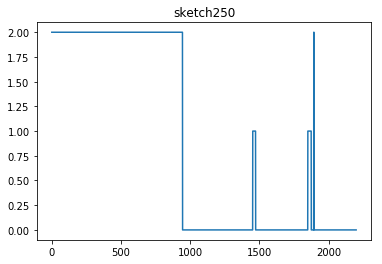

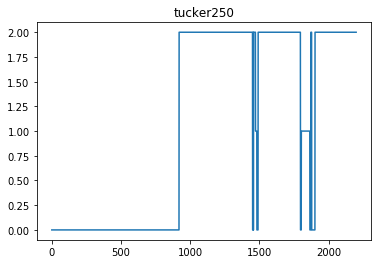

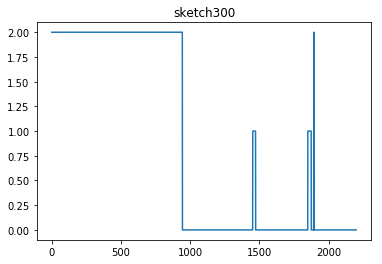

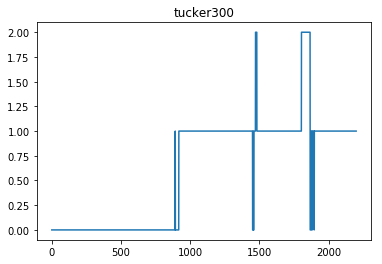

In [15]:
for k in [20,50,80,100,150,200,250,300]: 
    print(k)
    walk_sketch = load_sketch('walk_k'+str(k), 3)
    arm_sketches, core_sketch = walk_sketch
    [tucker_arms,tucker_core] = pickle.load(ee("data/walk_tucker_k"+str(k)+"_r"+str(10)+".pickle",'rb'))
    kmeans = KMeans(n_clusters =3,random_state=0).fit(arm_sketches[0][100:2300])
    plt.figure()
    plt.plot(kmeans.labels_)
    plt.title('sketch'+ str(k))
    kmeans2 = KMeans(n_clusters =3,random_state=0).fit(tucker_arms[0][100:2300])
    plt.figure()
    plt.plot(kmeans2.labels_)
    plt.title('tucker'+str(k))
    
    

In [15]:
for k in [20]: 
    print(k)
    walk_sketch = load_sketch('walk_k'+str(k), 3)
    arm_sketches, core_sketch = walk_sketch
    [tucker_arms,tucker_core] = pickle.load(open("data/walk_tucker_k"+str(k)+"_r"+str(20)+".pickle",'rb'))
    kmeans = KMeans(n_clusters =3,random_state=0).fit(arm_sketches[0][100:2300])
    plt.figure()
    plt.plot(kmeans.labels_)
    plt.title('sketch'+ str(k))
    kmeans2 = KMeans(n_clusters =3,random_state=0).fit(tucker_arms[0][100:2300])
    plt.figure()
    plt.plot(kmeans2.labels_)
    plt.title('tucker'+str(k))

20


FileNotFoundError: [Errno 2] No such file or directory: 'data/walk_tucker_k20_r20.pickle'

50
80
100
150
200
250
300


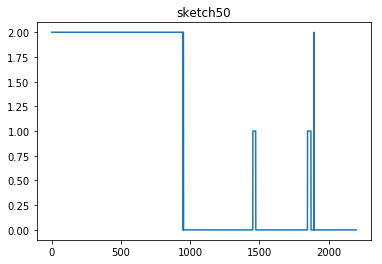

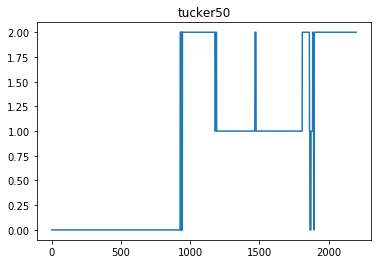

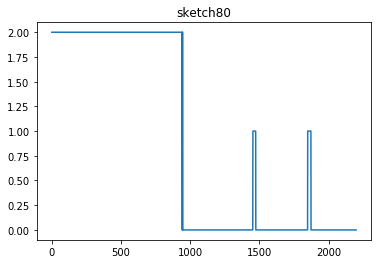

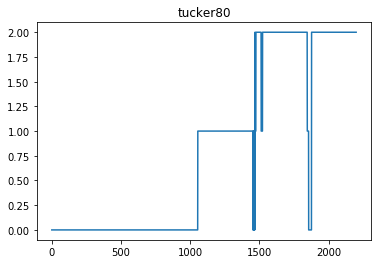

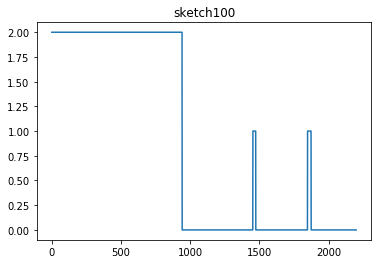

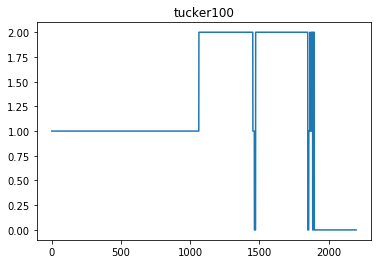

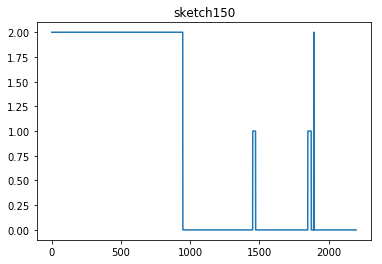

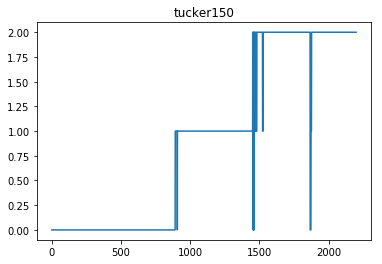

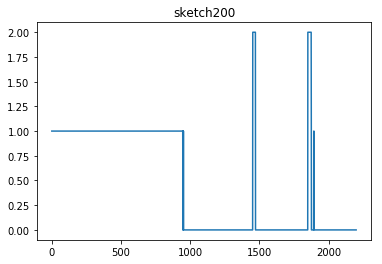

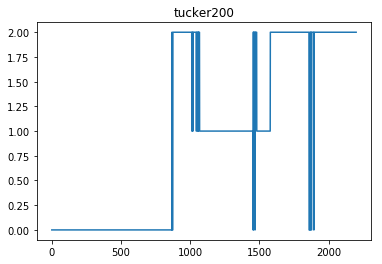

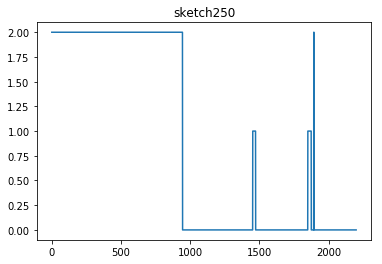

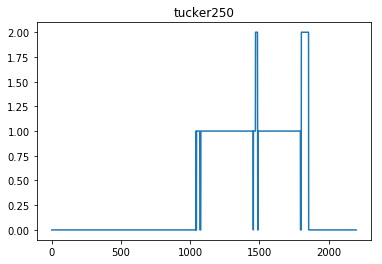

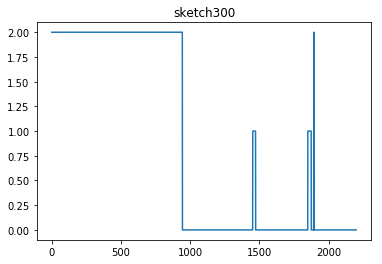

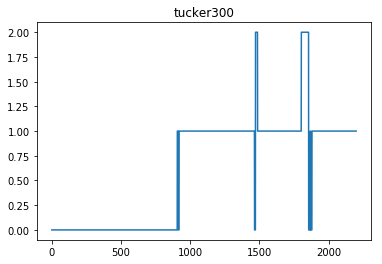

In [16]:
for k in [50,80,100,150,200,250,300]: 
    print(k)
    walk_sketch = load_sketch('walk_k'+str(k), 3)
    arm_sketches, core_sketch = walk_sketch
    [tucker_arms,tucker_core] = pickle.load(open("data/walk_tucker_k"+str(k)+"_r"+str(20)+".pickle",'rb'))
    kmeans = KMeans(n_clusters =3,random_state=0).fit(arm_sketches[0][100:2300])
    plt.figure()
    plt.plot(kmeans.labels_)
    plt.title('sketch'+ str(k))
    kmeans2 = KMeans(n_clusters =3,random_state=0).fit(tucker_arms[0][100:2300])
    plt.figure()
    plt.plot(kmeans2.labels_)
    plt.title('tucker'+str(k))

In [6]:
[tucker_arms,tucker_core] = pickle.load(open("data/walk_tucker_k"+str(300)+"_r"+str(10)+".pickle",'rb'))
Xhat = tl.tucker_to_tensor(tucker_core, tucker_arms)


In [18]:
data_norm2 = 0 
err_norm2 = 0
for idx, data_file in enumerate(["data/grey_walk"+str(i)+".npy" for i in np.arange(1)]): 
    data = np.load(data_file)
    data_norm2 = data_norm2 + np.linalg.norm(data)**2
    print(str(idx)+'data norm')
    err_norm2 = err_norm2+ np.linalg.norm(Xhat[idx*277:(idx+1)*277,:,:]-data)**2 
    print(str(idx)+'err norm')
print(np.sqrt(err_norm2/data_norm2))

0data norm
0err norm
0.3277907960932225


In [7]:
data_norm2 = 0 
err_norm2 = 0
for idx, data_file in enumerate(["data/grey_walk"+str(i)+".npy" for i in np.arange(9)]): 
    data = np.load(data_file)
    data_norm2 = data_norm2 + np.linalg.norm(data)**2
    print(str(idx)+'data norm')
    err_norm2 = err_norm2+ np.linalg.norm(Xhat[idx*277:(idx+1)*277,:,:]-data)**2 
    print(str(idx)+'err norm')
    print(np.sqrt(err_norm2/data_norm2))

0data norm
0err norm
0.3315967492277638
1data norm
1err norm
0.33117484078186576
2data norm
2err norm
0.33099536347587327
3data norm
3err norm
0.3302064880572808
4data norm
4err norm
0.3302242389777427
5data norm
5err norm
0.3318798319772064
6data norm
6err norm
0.3320776431084649
7data norm
7err norm
0.3316729622244591
8data norm
8err norm
0.3322743697585082


100
150
200
250
300


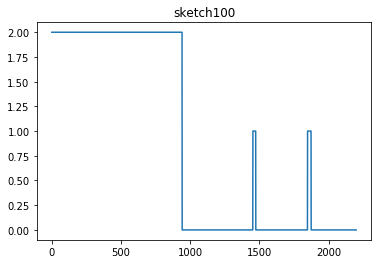

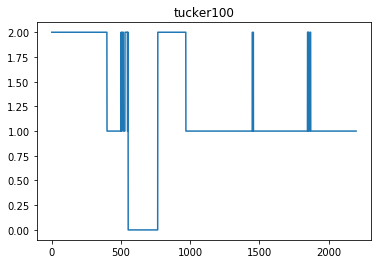

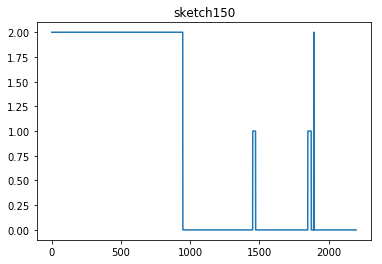

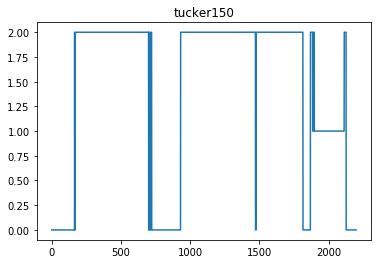

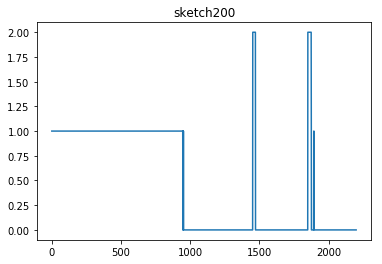

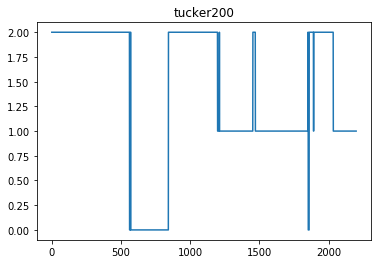

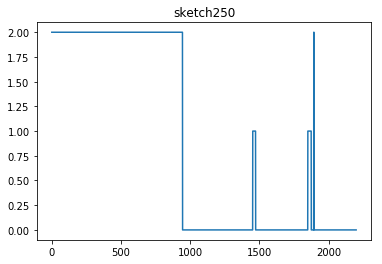

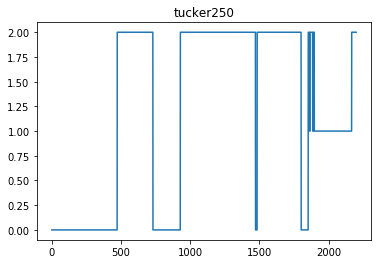

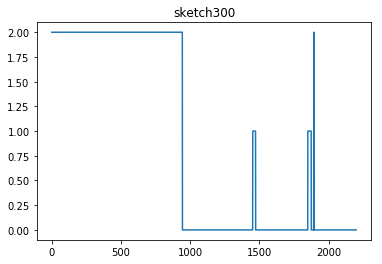

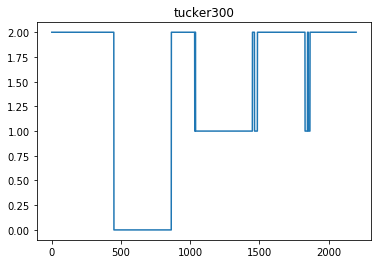

In [17]:
for k in [100,150,200,250,300]: 
    print(k)
    walk_sketch = load_sketch('walk_k'+str(k), 3)
    arm_sketches, core_sketch = walk_sketch
    [tucker_arms,tucker_core] = pickle.load(open("data/walk_tucker_k"+str(k)+"_r"+str(50)+".pickle",'rb'))
    kmeans = KMeans(n_clusters =3,random_state=0).fit(arm_sketches[0][100:2300])
    plt.figure()
    plt.plot(kmeans.labels_)
    plt.title('sketch'+ str(k))
    kmeans2 = KMeans(n_clusters =3,random_state=0).fit(tucker_arms[0][100:2300])
    plt.figure()
    plt.plot(kmeans2.labels_)
    plt.title('tucker'+str(k))

# Sample Video Scene Recovery

In [1]:
# Get the idx th frame from the original data
# Need to add 100, since the first 100 frames are omitted in the analysis
def get_frame(idx, save = False, fontsize = 28):
    test_frame = np.load("data/grey_walk"+str(np.floor_divide(idx+100, 277))+".npy")    
    result = test_frame[(idx+100)%277,:,:]
    plt.figure(figsize=(7,10))
    plt.imshow(result, cmap = 'gray')
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize) 
    plt.title('Frame '+str(idx), fontsize = fontsize)
    if save: 
        plt.tight_layout()
        plt.savefig('plots/frame'+str(idx)+'.pdf', bbox_inches = 'tight')
    return result

In [2]:
frame500 = get_frame(500, save = True)
frame1100 = get_frame(1100, save = True)
frame1465 = get_frame(1465, save = True)
frame1830 = get_frame(1830, save = True)

NameError: name 'np' is not defined

In [64]:
k20_twopass = pickle.load(open('data/walk_2pass_tucker_k20_r10.pickle','rb'))

In [9]:
def visualize_frame(tucker_arms, tucker_core, idx, filename ='', title = '', save = False, fontsize = 28): 
    idx = idx +100
    tucker_arms_new = [(tucker_arms[i][idx,:] if i == 0 else tucker_arms[i]) for i in range(3)] 
    frame = tl.tucker_to_tensor(tucker_core, tucker_arms_new)
    plt.figure(figsize=(7,10))
    plt.imshow(frame, cmap = 'gray')
    plt.yticks(fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.title(title, fontsize = fontsize)
    plt.tight_layout()
    if save: 
        plt.savefig('plots/'+filename+'.pdf', bbox_inches = 'tight')
    return frame

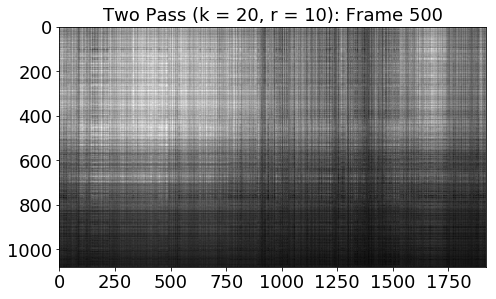

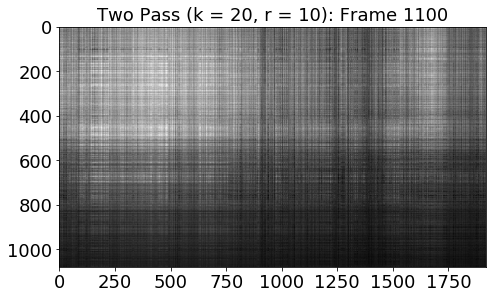

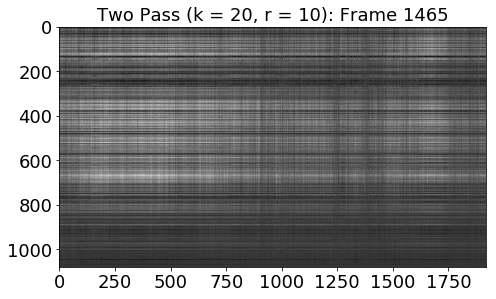

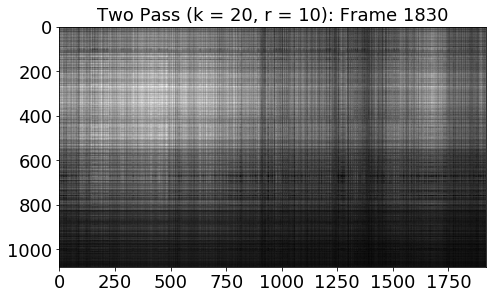

In [101]:
for idx in [500, 1100, 1465, 1830]: 
    visualize_frame(k20_twopass[0], k20_twopass[1],idx,\
                    title = 'Two Pass (k = 20, r = 10): Frame '+str(idx),\
                    filename = '2pass_k20_r10_frame'+str(idx), save = True)

In [102]:
k20_onepass = pickle.load(open('data/walk_tucker_k20_r10.pickle','rb'))
k300_onepass = pickle.load(open('data/walk_tucker_k300_r10.pickle','rb'))

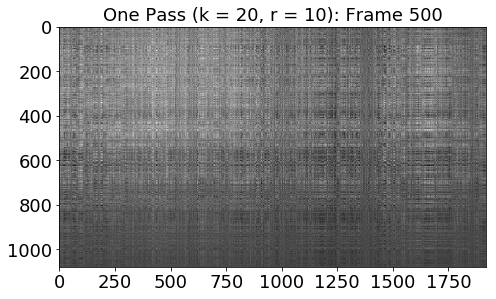

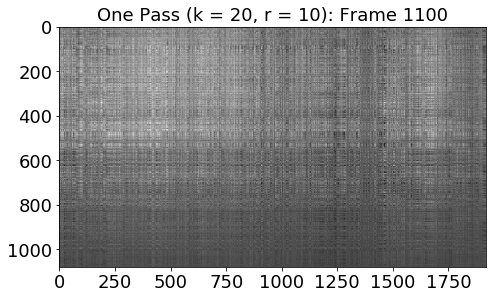

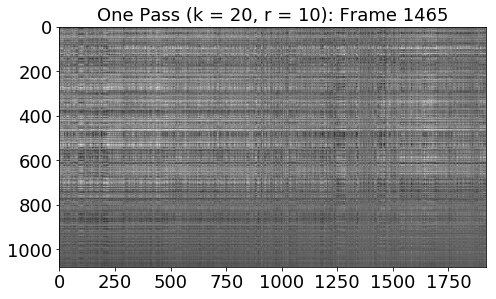

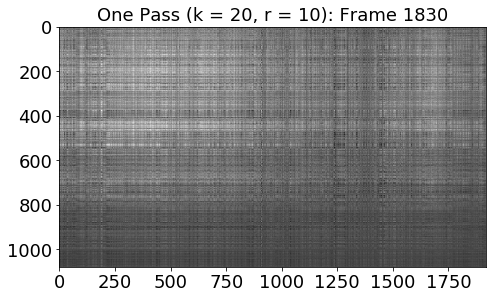

In [103]:
for idx in [500, 1100, 1465, 1830]: 
    visualize_frame(k20_onepass[0], k20_onepass[1],idx,\
                    title = 'One Pass (k = 20, r = 10): Frame '+str(idx),\
                    filename = '1pass_k20_r10_frame'+str(idx), save = True)

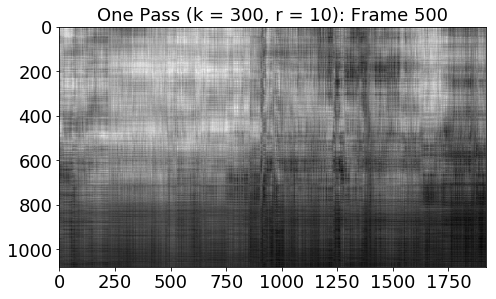

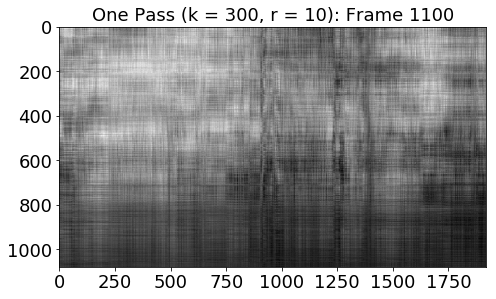

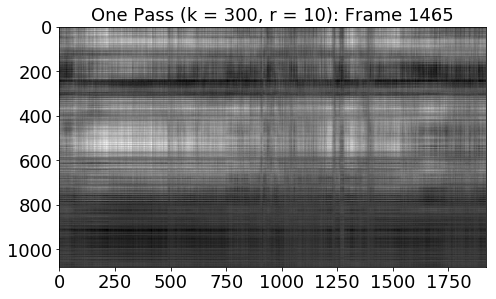

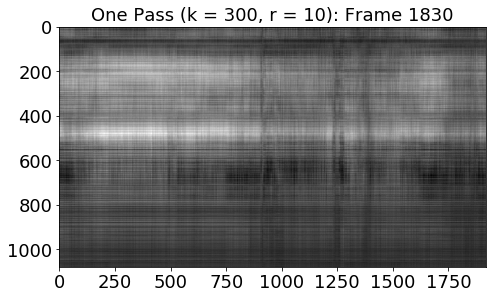

In [104]:
for idx in [500, 1100, 1465, 1830]: 
    visualize_frame(k300_onepass[0], k300_onepass[1],idx,\
                    title = 'One Pass (k = 300, r = 10): Frame '+str(idx),\
                    filename = '1pass_k300_r10_frame'+str(idx), save = True)

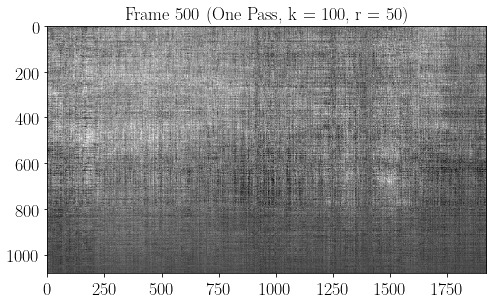

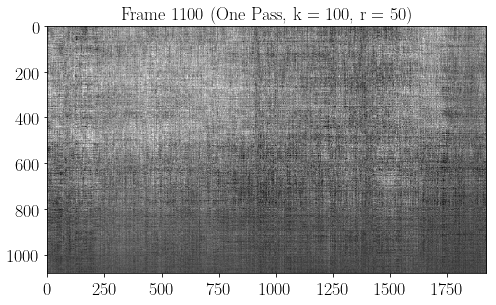

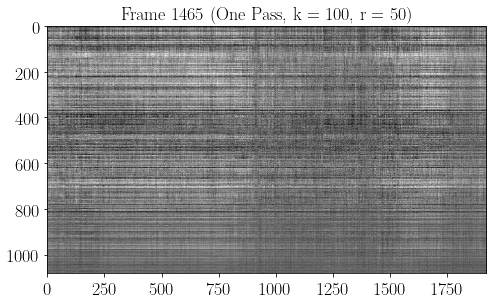

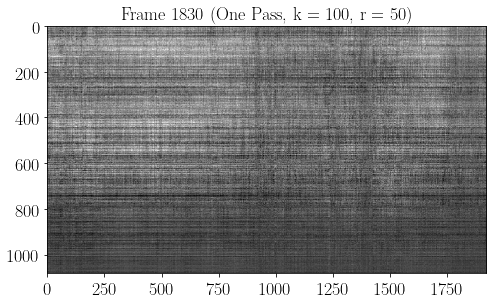

In [10]:
k100_onepass = pickle.load(open('data/walk_tucker_k100_r50.pickle','rb'))
for idx in [500, 1100, 1465, 1830]: 
    visualize_frame(k100_onepass[0], k100_onepass[1],idx,\
                    title = 'Frame {} (One Pass, k = 100, r = 50)'.format(idx),\
                    filename = '1pass_k100_r50_frame'+str(idx), save = True)

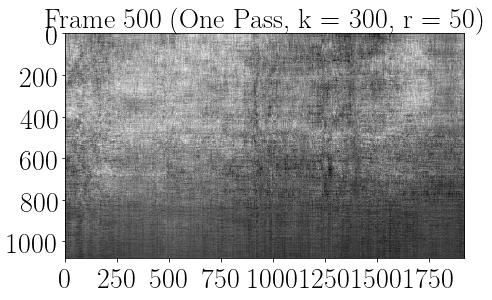

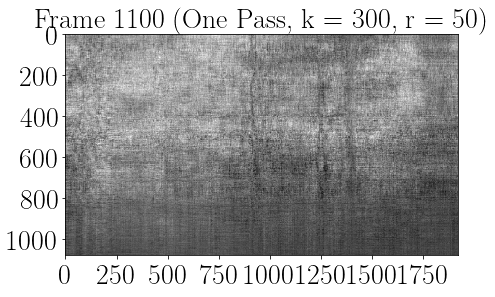

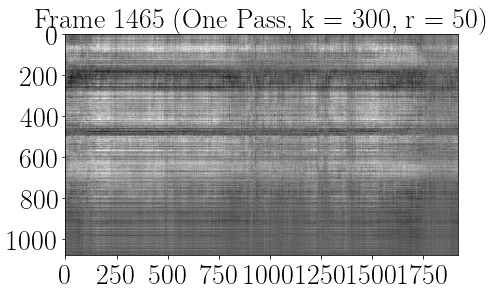

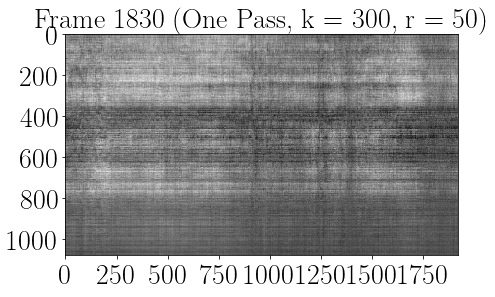

In [10]:
k300_onepass = pickle.load(open('data/walk_tucker_k300_r50.pickle','rb'))
for idx in [500, 1100, 1465, 1830]: 
    visualize_frame(k300_onepass[0], k300_onepass[1],idx,\
                    title = 'Frame {} (One Pass, k = 300, r = 50)'.format(idx),\
                    filename = '1pass_k300_r50_frame'+str(idx), save = True)

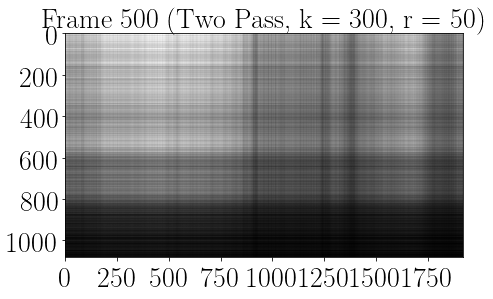

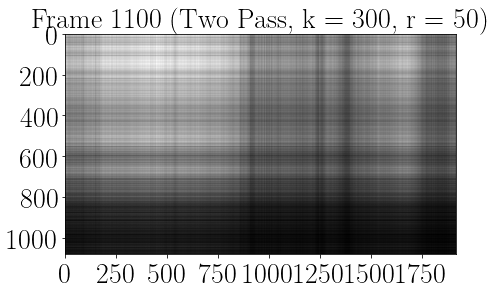

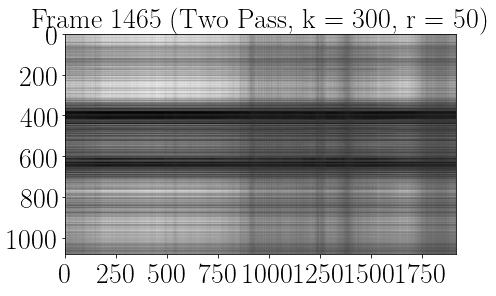

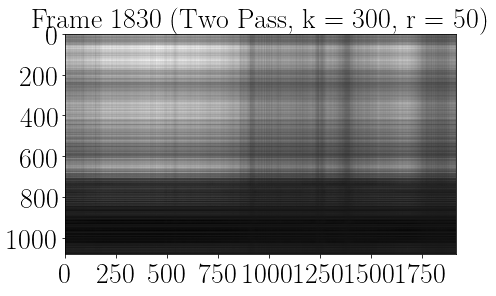

In [11]:
k300_twopass = pickle.load(open('data/walk_2pass_tucker_k300_r50503.pickle','rb'))
for idx in [500, 1100, 1465, 1830]: 
    visualize_frame(k300_twopass[0], k300_twopass[1],idx,\
                    title = 'Frame {} (Two Pass, k = 300, r = 50)'.format(idx),\
                    filename = '2pass_k300_r50_frame'+str(idx), save = True)

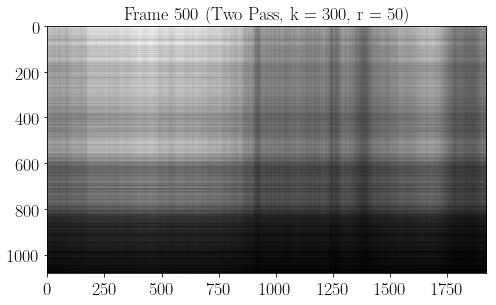

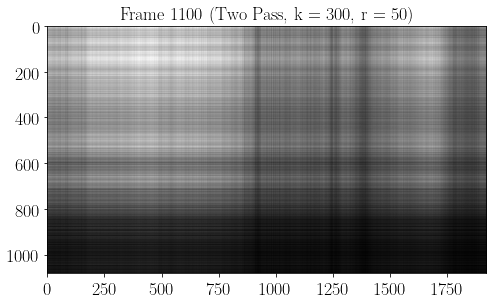

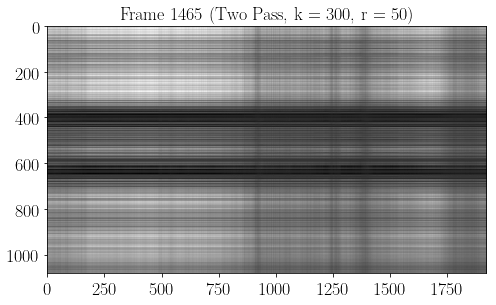

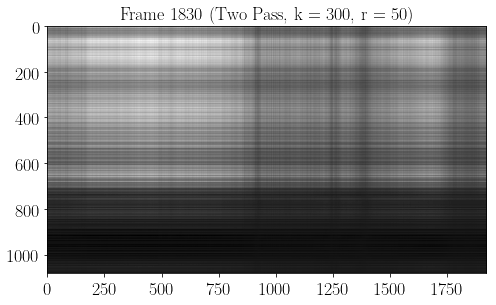

In [10]:
k300_twopass = pickle.load(open('data/walk_2pass_tucker_k300_r50503.pickle','rb'))
for idx in [500, 1100, 1465, 1830]: 
    visualize_frame(k300_twopass[0], k300_twopass[1],idx,\
                    title = 'Frame {} (Two Pass, k = 300, r = 50)'.format(idx),\
                    filename = '2pass_k300_r50_frame'+str(idx), save = True)
